In [128]:
path = "data/raw_data/P03/"
# perfect: 3,4,5,6
# problems:
# - 1 wrong sequence sync
# - 2 wrong number of sequences->first should be excluded

**Schedule**

1. Load Isoforce data and extract torque segments.
2. Load Isoforce data recorded with Python and extract torque segments with time stamps.
3. Combine the Isoforce data segments with the time stamps from the Isoforce Python data.
4. Load EIT data sequences measurement timestamps and combine them with the right interpolated Isoforce torque values.

In [129]:
import os
from datetime import timedelta
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from src import (
    IsoforceIso,
    IsoforcePy,
    ProcessingDir,
    Protocol,
    process_sciospec_eit,
    renderDF,
    scale_to_range,
)

_1. Load Isoforce data and extract torque segments._

Fund participant data:

Head directory: self.path='data/serious_data/Final_Measurements/P01/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='data/serious_data/Final_Measurements/P01/EIT_P01_raw_data_12012025114030.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='data/serious_data/Final_Measurements/P01/iso_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='data/serious_data/Final_Measurements/P01/eit_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='data/serious_data/Final_Measurements/P01/eit_raw/20250218 17.03.01/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='data/serious_data/Final_Measurements/P01/EIT_processed/'
[40 40 80 80 70 70 30 30 20 20 60 60 50 50]
!!!The torque data is lowpass filtered!!!
!!!The angle data is lowpass filtered!!!


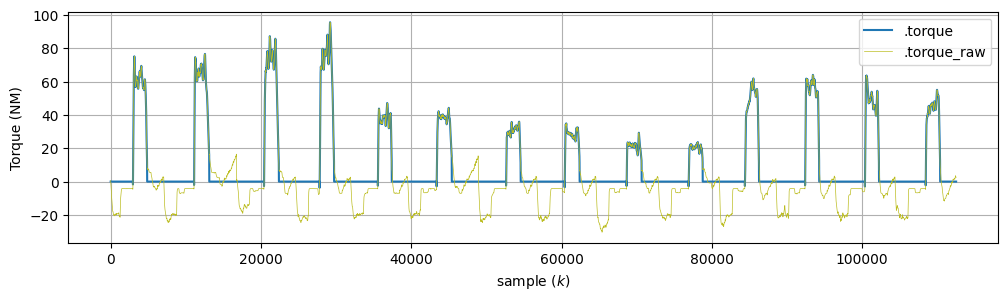

In [130]:
part_path = ProcessingDir(path)
protocol = Protocol(part_path.path, prints=False)
print(protocol.IsokinetikMeasurement.force_levels)

DF = renderDF(part_path.isoforce_iso)

isoforce_iso = IsoforceIso(DF, LP_filter=True)
isoforce_iso.plot_torque()

_2. Load Isoforce data recorded with Python and extract torque segments with time stamps._

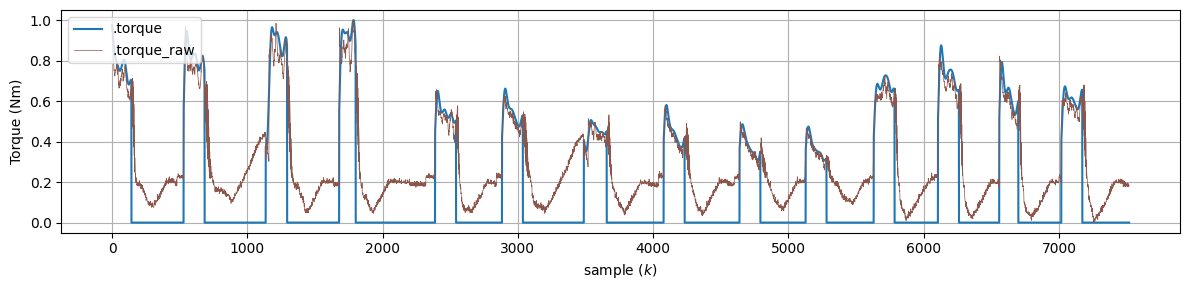

In [131]:
isoforce_py = IsoforcePy(
    part_path.isoforce_py_raw,
    protocol,
    LP_filter=True,
    over_UTC=False,
    scale_0_1=True,
)
isoforce_py.plot_torque()

In [132]:
# isoforce_py.torque_segments
# isoforce_py.timestamp_segments

_3. Combine the Isoforce data segments with the time stamps from the Isoforce Python data._

In [133]:
assert len(isoforce_iso.torque_segments.keys()) == len(
    isoforce_py.torque_segments.keys()
)

In [134]:
print(isoforce_iso.torque_segments.keys())
print(isoforce_py.torque_segments.keys())
print(isoforce_py.timestamp_segments.keys())

dict_keys(['T_seg_0', 'T_seg_1', 'T_seg_2', 'T_seg_3', 'T_seg_4', 'T_seg_5', 'T_seg_6', 'T_seg_7', 'T_seg_8', 'T_seg_9', 'T_seg_10', 'T_seg_11', 'T_seg_12', 'T_seg_13'])
dict_keys(['T_seg_0', 'T_seg_1', 'T_seg_2', 'T_seg_3', 'T_seg_4', 'T_seg_5', 'T_seg_6', 'T_seg_7', 'T_seg_8', 'T_seg_9', 'T_seg_10', 'T_seg_11', 'T_seg_12', 'T_seg_13'])
dict_keys(['ts_seg_0', 'ts_seg_1', 'ts_seg_2', 'ts_seg_3', 'ts_seg_4', 'ts_seg_5', 'ts_seg_6', 'ts_seg_7', 'ts_seg_8', 'ts_seg_9', 'ts_seg_10', 'ts_seg_11', 'ts_seg_12', 'ts_seg_13'])


In [135]:
def sync_NI_PY_times(
    isoforce_iso, isoforce_py, seg_idx: int = 1, plotting: bool = True
):
    tmp_iso_seg = isoforce_iso.torque_segments[f"T_seg_{seg_idx}"]
    tmp_py_seg = isoforce_py.torque_segments[f"T_seg_{seg_idx}"]
    tmp_ts_seg = isoforce_py.timestamp_segments[f"ts_seg_{seg_idx}"]

    indices = np.linspace(0, len(tmp_iso_seg) - 1, len(tmp_py_seg), dtype=int)
    assert len(indices) == len(tmp_py_seg)
    sampled_iso = tmp_iso_seg[indices]

    if plotting:
        plt.figure(figsize=(6, 2))
        plt.title(f"Segment index {seg_idx}")
        plt.plot(tmp_iso_seg, label="NI-iso")
        plt.scatter(
            indices, sampled_iso, marker="x", s=20, c="C1", label="EIT timestamps"
        )
        plt.legend()
        # plt.hlines(protocol.IsokinetikMeasurement.force_levels[seg_idx],xmin=0,xmax=max(indices))
        plt.ylabel("torque (NM)")
        plt.xlabel("Segment time indices $k$")
        plt.grid()
        plt.show()
    return tmp_ts_seg, sampled_iso

    EIT
    #targe force
    measured force
    time_stamp
    participant

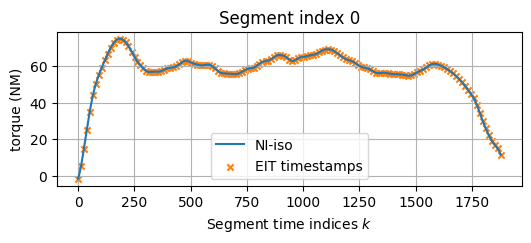

In [136]:
tmp_ts_seg, sampled_iso = sync_NI_PY_times(
    isoforce_iso, isoforce_py, seg_idx=0, plotting=True
)

_4. Load EIT data sequences measurement timestamps and combine them with the right interpolated Isoforce torque values._

In [137]:
def load_eit_npz(part_path):
    times_eit = list()
    eit = list()
    for ele in np.sort(glob(part_path.s_path_eit + "*.npz")):
        tmp = np.load(ele, allow_pickle=True)
        times_eit.append(tmp["timestamp"])
        eit.append(tmp["eit"])
    times_eit = np.array(times_eit)
    eit = np.array(eit)
    return times_eit, eit


def find_closest_index(array, value):
    """Used for time sync between eit and isoforce"""
    index = np.argmin(np.abs(array - value))
    return index


from dtaidistance import dtw


def find_best_match(long_series, reference, window_size=4):
    best_index = None
    best_distance = float("inf")

    for i in range(len(long_series) - window_size + 1):
        segment = long_series[i : i + window_size]
        distance = dtw.distance(reference, segment)

        if distance < best_distance:
            best_distance = distance
            best_index = i

    return best_index, best_distance

In [138]:
def sync_eit_ISO_segments(
    part_path, isoforce_iso, isoforce_py, mode="fast", plotting: bool = True
):
    eit_start_ts = 0
    EIT = list()
    TORQUE = list()
    TS_iso = list()
    TS_eit = list()

    print("Loading eit...")
    times_eit, eit = load_eit_npz(part_path)

    print("Matching sequences...")
    for seg_idx in range(len(isoforce_iso.torque_segments.keys())):
        tmp_ts_seg, sampled_iso = sync_NI_PY_times(
            isoforce_iso, isoforce_py, seg_idx, plotting
        )

        if mode == "fast":
            eit_start_ts = find_closest_index(times_eit, tmp_ts_seg[0])
            eit_stop_ts = find_closest_index(times_eit, tmp_ts_seg[-1])
            print(
                f"detected start idx values{tmp_ts_seg[0]=}, {times_eit[eit_start_ts]=}"
            )
            print(f"{eit_start_ts=}, {eit_stop_ts=}, diff:{eit_stop_ts-eit_start_ts}")
        elif mode == "slow":
            eit_start_ts, eit_start_distance = find_best_match(
                times_eit, tmp_ts_seg[:5]
            )
            print(
                f"Best match at index: {eit_start_ts}, DTW-distanz: {eit_start_distance}"
            )

        print(
            eit_start_ts,
            "diff start:",
            tmp_ts_seg[0] - times_eit[eit_start_ts],
            "diff end:",
            tmp_ts_seg[0 - 1] - times_eit[eit_start_ts + len(tmp_ts_seg)],
        )
        assert len(times_eit[eit_start_ts : eit_start_ts + len(tmp_ts_seg)]) == len(
            tmp_ts_seg
        )

        # corresponding eit sequence:
        eit_sync_seq = eit[eit_start_ts : eit_start_ts + len(tmp_ts_seg)]
        eit_ts_seq = times_eit[eit_start_ts : eit_start_ts + len(tmp_ts_seg)]
        assert (
            len(eit_sync_seq) == len(tmp_ts_seg) == len(sampled_iso) == len(eit_ts_seq)
        )

        # plt.figure(figsize=(6, 2))
        # plt.title("err")
        # plt.plot(times_eit[eit_start_ts:eit_start_ts+len(tmp_ts_seg)]-tmp_ts_seg)
        # plt.show()

        EIT.append(eit_sync_seq)
        TORQUE.append(sampled_iso)
        TS_iso.append(tmp_ts_seg)
        TS_eit.append(eit_ts_seq)

    EIT = np.concatenate(EIT)
    TORQUE = np.concatenate(TORQUE)
    # TS_iso = np.concatenate(TS_iso)
    # TS_eit = np.concatenate(TS_eit)

    return EIT, TORQUE, TS_iso, TS_eit

Loading eit...
Matching sequences...


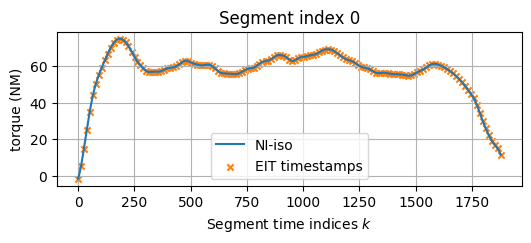

detected start idx valuestmp_ts_seg[0]=1739916186.0, times_eit[eit_start_ts]=1739916186.008
eit_start_ts=153, eit_stop_ts=295, diff:142
153 diff start: -0.007999897003173828 diff end: -0.03299999237060547


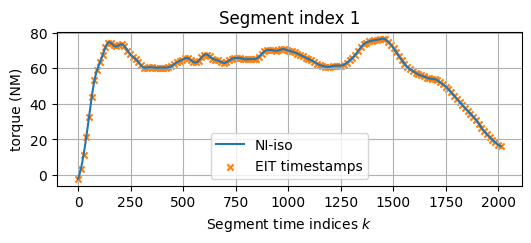

detected start idx valuestmp_ts_seg[0]=1739916244.225, times_eit[eit_start_ts]=1739916244.23
eit_start_ts=2482, eit_stop_ts=2636, diff:154
2482 diff start: -0.005000114440917969 diff end: -0.029999971389770508


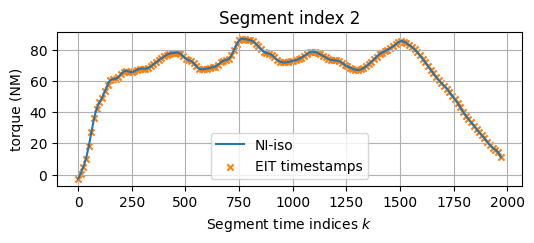

detected start idx valuestmp_ts_seg[0]=1739916259.4, times_eit[eit_start_ts]=1739916259.404
eit_start_ts=3089, eit_stop_ts=5246, diff:2157
3089 diff start: -0.003999948501586914 diff end: 49.97099995613098


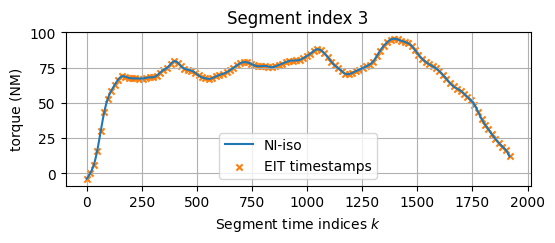

detected start idx valuestmp_ts_seg[0]=1739916322.975, times_eit[eit_start_ts]=1739916322.977
eit_start_ts=5632, eit_stop_ts=7433, diff:1801
5632 diff start: -0.002000093460083008 diff end: 41.973999977111816


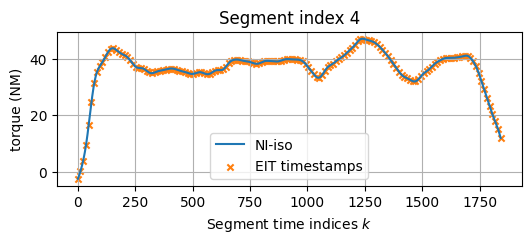

detected start idx valuestmp_ts_seg[0]=1739916490.7, times_eit[eit_start_ts]=1739916490.693
eit_start_ts=12341, eit_stop_ts=12495, diff:154
12341 diff start: 0.006999969482421875 diff end: -0.018000125885009766


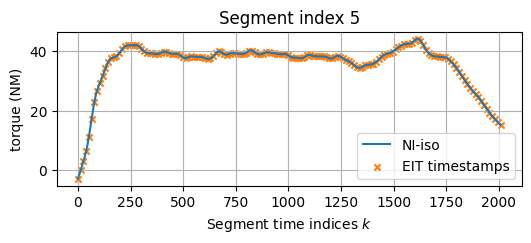

detected start idx valuestmp_ts_seg[0]=1739916551.075, times_eit[eit_start_ts]=1739916551.065
eit_start_ts=14756, eit_stop_ts=14909, diff:153
14756 diff start: 0.009999990463256836 diff end: -0.014999866485595703


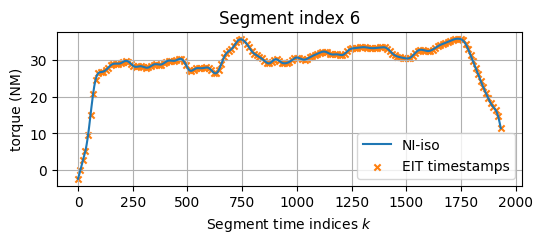

detected start idx valuestmp_ts_seg[0]=1739916566.2, times_eit[eit_start_ts]=1739916566.19
eit_start_ts=15361, eit_stop_ts=17330, diff:1969
15361 diff start: 0.009999990463256836 diff end: 44.986000061035156


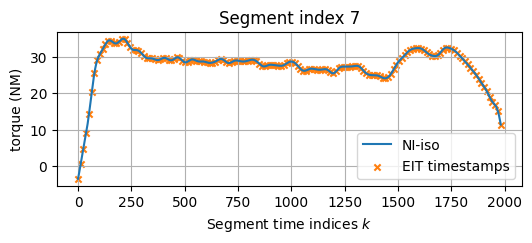

detected start idx valuestmp_ts_seg[0]=1739916672.95, times_eit[eit_start_ts]=1739916672.959
eit_start_ts=19632, eit_stop_ts=19786, diff:154
19632 diff start: -0.009000062942504883 diff end: -0.03400015830993652


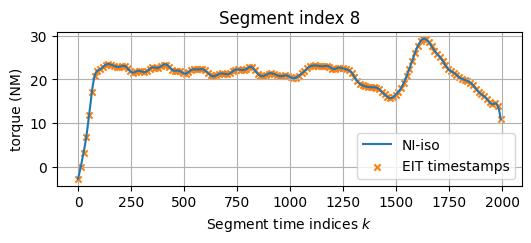

detected start idx valuestmp_ts_seg[0]=1739916733.975, times_eit[eit_start_ts]=1739916733.981
eit_start_ts=22073, eit_stop_ts=22226, diff:153
22073 diff start: -0.006000041961669922 diff end: -0.031000137329101562


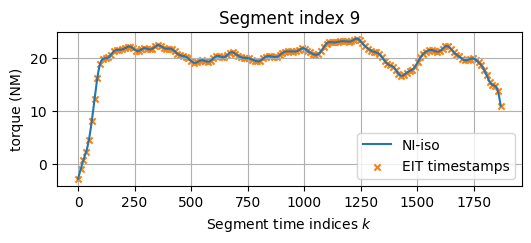

detected start idx valuestmp_ts_seg[0]=1739916787.2, times_eit[eit_start_ts]=1739916787.203
eit_start_ts=24202, eit_stop_ts=24355, diff:153
24202 diff start: -0.003000020980834961 diff end: -0.0279998779296875


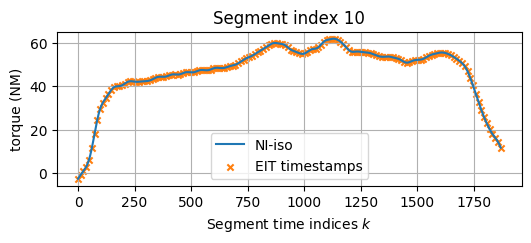

detected start idx valuestmp_ts_seg[0]=1739916843.775, times_eit[eit_start_ts]=1739916843.775
eit_start_ts=26465, eit_stop_ts=26618, diff:153
26465 diff start: 0.0 diff end: -0.02500009536743164


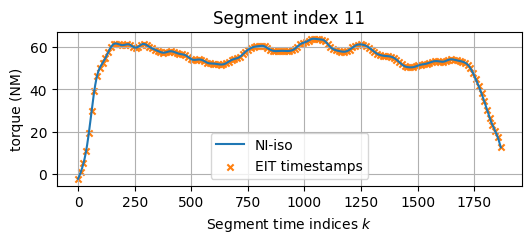

detected start idx valuestmp_ts_seg[0]=1739916899.65, times_eit[eit_start_ts]=1739916899.647
eit_start_ts=28700, eit_stop_ts=28854, diff:154
28700 diff start: 0.003000020980834961 diff end: -0.02200007438659668


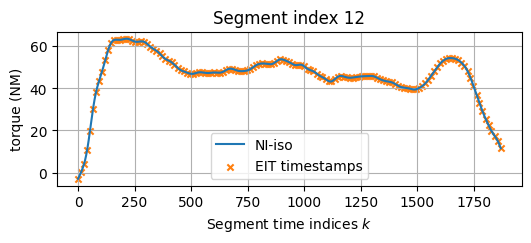

detected start idx valuestmp_ts_seg[0]=1739916910.975, times_eit[eit_start_ts]=1739916910.972
eit_start_ts=29153, eit_stop_ts=31333, diff:2180
29153 diff start: 0.003000020980834961 diff end: 50.978999853134155


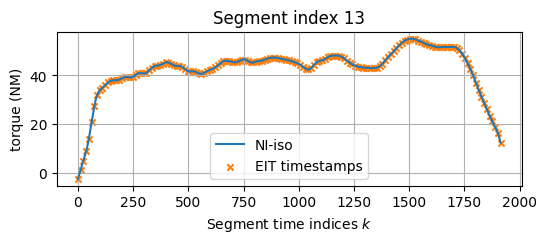

detected start idx valuestmp_ts_seg[0]=1739917020.45, times_eit[eit_start_ts]=1739917020.441
eit_start_ts=33532, eit_stop_ts=33686, diff:154
33532 diff start: 0.009000062942504883 diff end: -0.015000104904174805


In [139]:
EIT, TORQUE, TS_iso, TS_eit = sync_eit_ISO_segments(
    part_path, isoforce_iso, isoforce_py
)

In [100]:
EIT.shape, TORQUE.shape, TS_iso.shape, TS_eit.shape

AttributeError: 'list' object has no attribute 'shape'

In [140]:
len(TS_iso), len(TS_eit)

(14, 14)

In [141]:
# times_eit, eit = load_eit_npz(part_path)
# time_py = [dt.timestamp() for dt in isoforce_py.time]

In [142]:
TS_iso = np.concatenate(TS_iso)
TS_eit = np.concatenate(TS_eit)

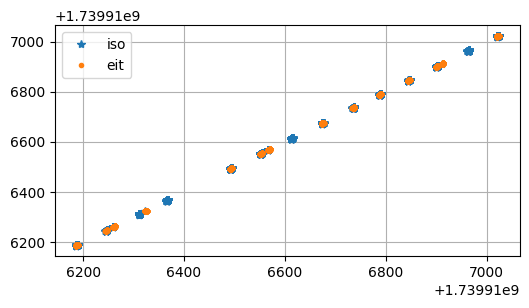

In [143]:
plt.figure(figsize=(6, 3))
# plt.plot(times_eit, times_eit, ".", label="time EIT device")
plt.plot(TS_iso, TS_iso, "*", label="iso")
plt.plot(TS_eit, TS_eit, ".", label="eit")
plt.legend()
plt.grid()
# plt.xlim([6400,6600])
plt.show()

**TESTING TIME SYNC#2**

In [ ]:
datetime.fromtimestamp(times_eit[2482])

In [ ]:
T_EIT, eit = load_eit_npz(part_path)

SEQ, sampled_iso = sync_NI_PY_times(
    isoforce_iso, isoforce_py, seg_idx=1, plotting=False
)

# T_EIT = np.array([datetime.fromtimestamp(ts) for ts in T_EIT])
# SEQ =  np.array([datetime.fromtimestamp(ts) for ts in SEQ])

In [54]:
T_EIT.shape, SEQ.shape

((34358,), (155,))

In [56]:
find_best_match(T_EIT, SEQ)

(2557, 13.390906948579936)

In [57]:
%time find_best_match(T_EIT,SEQ)

CPU times: user 31.4 s, sys: 2.41 ms, total: 31.4 s
Wall time: 31.4 s


(2557, 13.390906948579936)